In [1]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
import sys
sys.path.append('./functions')

import warnings
warnings.filterwarnings('ignore')

from functions.checks_and_preprocessing.missing_or_nan import check_missing_or_nan
from functions.checks_and_preprocessing.stationarity_normality import kpss_adf_stationarity, normality_testing
from functions.data_load_and_transform.sql_connections import get_database_connector, get_beach_data
from functions.plotting.data_and_acf import create_widgets_and_plot

In [2]:
# We select one beach (via index), read it's data from the SQL database, and check for missing hours and NaN values
DATA_STARTDATE = "1979-01-01"
DATA_ENDDATE = "2021-12-31"

single_beach_data, beach_name_sql_table = get_beach_data(get_database_connector())
check_missing_or_nan(single_beach_data, beach_name_sql_table, DATA_STARTDATE, DATA_ENDDATE)


Selected Beach Details:
силистар
No missing hours in силистар.
No NaN in силистар


In [3]:
percentiles = [0.05, .10, .25, .5, .75, .90, .95]
single_beach_data.describe(percentiles=percentiles)

,VTMX,VHM0_WW,VZMX,VMDR_SW2,VMDR,VMDR_SW1,VTM10,VPED,VTPK,VTM02,VHM0_SW1,VMDR_WW,VTM01_SW2,VSDX,VTM01_SW1,VSDY,VHM0,VTM01_WW,VHM0_SW2
count,376944.000000,376944.000000,376944.000000,376944.000000,376944.000000,376944.000000,376944.000000,376944.000000,376944.000000,376944.000000,376944.000000,376944.000000,376944.000000,376944.000000,376944.000000,376944.000000,376944.000000,376944.000000,376944.000000
mean,4.062734,0.424709,1.382679,128.229444,73.410849,83.034613,4.383151,72.602658,5.235563,3.426313,0.413646,134.956730,7.657055,-0.021160,4.259847,-0.030157,0.811858,2.074654,0.032015
std,1.053632,0.624675,1.182104,96.469069,55.576573,52.019360,1.228437,53.246500,1.535443,0.986501,0.383209,108.613573,7.886955,0.037465,1.283463,0.058350,0.622434,1.147467,0.066206
min,1.589031,0.010545,0.019536,0.000610,0.002319,0.001190,1.297298,0.015625,1.509112,1.131983,0.000000,0.000000,0.000000,-0.321853,0.000000,-0.379958,0.115944,1.000000,0.000000
5%,2.501122,0.020233,0.226212,17.034216,23.046213,28.768045,2.527240,23.053894,2.940834,1.944592,0.025827,8.798045,0.000000,-0.094659,2.458339,-0.148752,0.218854,1.000000,0.000000
10%,2.747599,0.026502,0.335548,25.819272,30.261035,35.526779,2.843742,27.255573,3.234917,2.171739,0.043651,16.235205,1.813550,-0.068880,2.726178,-0.113099,0.275060,1.000000,0.000136
25%,3.280564,0.052825,0.574063,52.618706,41.527939,51.164734,3.488757,37.289566,4.305675,2.691128,0.122580,35.649719,2.158447,-0.035247,3.331749,-0.054892,0.394528,1.240917,0.000624
50%,3.983885,0.171809,1.024316,96.421066,62.434967,73.411011,4.300359,67.716995,5.209867,3.369271,0.308512,120.990555,2.966668,-0.013251,4.156889,-0.012251,0.621714,1.676282,0.003934
75%,4.737000,0.498402,1.790923,172.500000,81.825844,94.386749,5.168965,82.152077,6.303939,4.074653,0.592826,194.792538,16.529614,-0.001884,5.000637,0.000389,1.014953,2.525899,0.029130
90%,5.460663,1.228340,2.936740,307.500000,127.683112,144.329941,6.003558,126.467130,6.934334,4.733276,0.920600,324.909222,20.590723,0.014616,5.851319,0.023546,1.609664,3.813832,0.102950


In [4]:
# We check if there are zero-valued or negative-valued features
zero_var_list = []
negative_var_list = []
for variable in single_beach_data.columns:
    if any(single_beach_data[variable] == 0):
        zero_var_list.append(variable)
    if any(single_beach_data[variable] < 0):
        negative_var_list.append(variable)

print(f'Features with zero values: {zero_var_list}') 
print(f'Features with negative values: {negative_var_list}') 


Features with zero values: ['VHM0_SW1', 'VMDR_WW', 'VTM01_SW2', 'VTM01_SW1', 'VHM0_SW2']
Features with negative values: ['VSDX', 'VSDY']


In [5]:
# Perform Kwiatkowski-Phillips-Schmidt-Shin (KPSS) and Augmented Dickey-Fuller (ADF) stationarity tests 
# on every column
stationarity_dict = {}
for col in single_beach_data.columns:
    kpssh, adfh = kpss_adf_stationarity(single_beach_data[col])
    stationarity_dict[col] = [kpssh, adfh]

pprint.pprint(stationarity_dict)

{'VHM0': ['KPSS - Stationary', 'ADF - Stationary'],
 'VHM0_SW1': ['KPSS - Stationary', 'ADF - Stationary'],
 'VHM0_SW2': ['KPSS - Stationary', 'ADF - Stationary'],
 'VHM0_WW': ['KPSS - Stationary', 'ADF - Stationary'],
 'VMDR': ['KPSS - Non-stationary (possible trend)', 'ADF - Stationary'],
 'VMDR_SW1': ['KPSS - Stationary', 'ADF - Stationary'],
 'VMDR_SW2': ['KPSS - Stationary', 'ADF - Stationary'],
 'VMDR_WW': ['KPSS - Non-stationary (possible trend)', 'ADF - Stationary'],
 'VPED': ['KPSS - Stationary', 'ADF - Stationary'],
 'VSDX': ['KPSS - Non-stationary (possible trend)', 'ADF - Stationary'],
 'VSDY': ['KPSS - Stationary', 'ADF - Stationary'],
 'VTM01_SW1': ['KPSS - Stationary', 'ADF - Stationary'],
 'VTM01_SW2': ['KPSS - Stationary', 'ADF - Stationary'],
 'VTM01_WW': ['KPSS - Stationary', 'ADF - Stationary'],
 'VTM02': ['KPSS - Stationary', 'ADF - Stationary'],
 'VTM10': ['KPSS - Stationary', 'ADF - Stationary'],
 'VTMX': ['KPSS - Stationary', 'ADF - Stationary'],
 'VTPK': ['KPSS

In their paper “Applying LSTM to Time Series Predictable through Time-Window Approaches”, Gers, Eck and Schmidhuber claim 
"Our results suggest to use LSTM only on tasks where traditional time window-based approaches must fail.
LSTM’s ability to track slow oscillations in the chaotic signal may be applicable to cognitive domains such as rhythm detection in speech and music."
Based on that, we do not apply differentiation to non-stationary columns at this point, seeing as how LTSM's could excel at handling such datasets.

In [6]:
# Carry out 4 normality tests
normality_dict = {}
for col in single_beach_data.columns:
    normality_results = normality_testing(single_beach_data[col])
    normality_dict[col] = normality_results

pprint.pprint(normality_dict)

{'VHM0': {'Anderson-Darling': 'Non-normality',
          "D'Agostino-Pearson": 'Non-normality',
          'Kolmogorov-Smirnov': 'Non-normality',
          'Shapiro-Wilk': 'Non-normality'},
 'VHM0_SW1': {'Anderson-Darling': 'Non-normality',
              "D'Agostino-Pearson": 'Non-normality',
              'Kolmogorov-Smirnov': 'Non-normality',
              'Shapiro-Wilk': 'Non-normality'},
 'VHM0_SW2': {'Anderson-Darling': 'Non-normality',
              "D'Agostino-Pearson": 'Non-normality',
              'Kolmogorov-Smirnov': 'Non-normality',
              'Shapiro-Wilk': 'Non-normality'},
 'VHM0_WW': {'Anderson-Darling': 'Non-normality',
             "D'Agostino-Pearson": 'Non-normality',
             'Kolmogorov-Smirnov': 'Non-normality',
             'Shapiro-Wilk': 'Non-normality'},
 'VMDR': {'Anderson-Darling': 'Non-normality',
          "D'Agostino-Pearson": 'Non-normality',
          'Kolmogorov-Smirnov': 'Non-normality',
          'Shapiro-Wilk': 'Non-normality'},
 'VMDR_SW1'

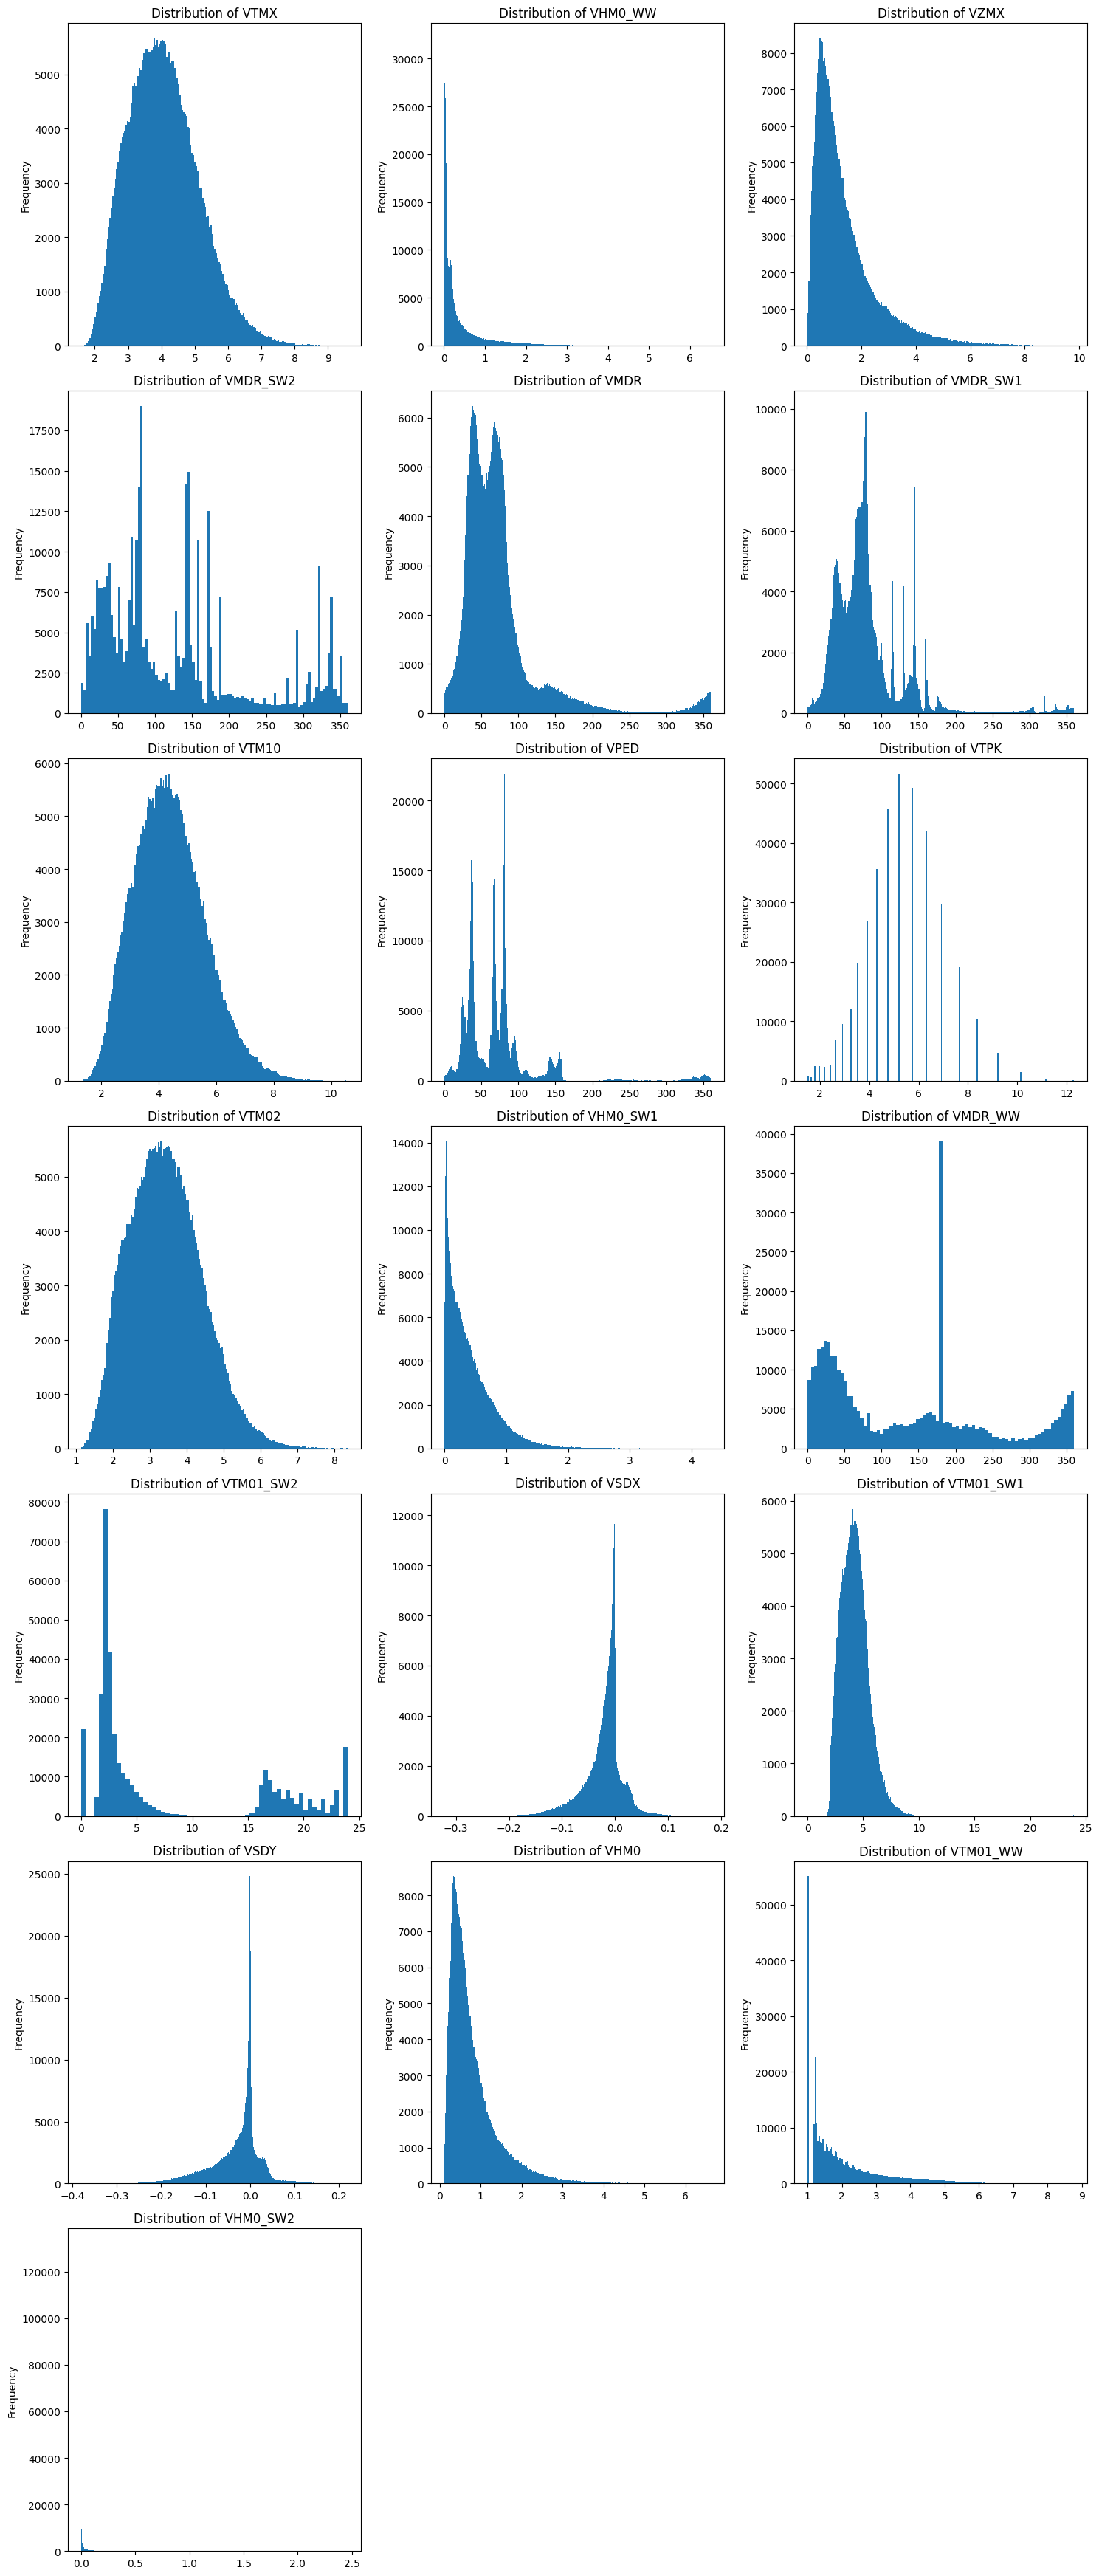

In [7]:
# Checking distribution of each column. Binning done with Freedman-Diaconis Rule.

# Calculate the number of rows needed for subplots
num_vars = len(single_beach_data.columns)
num_rows = math.ceil(num_vars / 3)

fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, num_rows*5))

# Flatten the axes array and iterate over it and the columns at the same time
for ax, column in zip(axs.flatten(), single_beach_data.columns):
    IQR = single_beach_data[column].quantile(0.75) - single_beach_data[column].quantile(0.25)
    h = 2 * IQR * (len(single_beach_data[column])**(-1/3))
    num_bins = int((single_beach_data[column].max() - single_beach_data[column].min()) / h)
    
    single_beach_data[column].plot(kind='hist', bins=num_bins, ax=ax)
    ax.set_title(f'Distribution of {column}')

# Remove unused subplots
for i in range(num_vars, num_rows*3):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

In [ ]:
corr = single_beach_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(16, 11))
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True)
plt.show()

In [ ]:
# Interactive plot to help visualize the data and ACF/PACF, with customizable options.
create_widgets_and_plot(single_beach_data)